# AG News Topic Classifier (BERT)
- Fine-tune `bert-base-uncased` on AG News headlines
- Metrics: Accuracy, Macro F1
- Export: Saved tokenizer+model
- Deployment: Gradio app

**References**: DevelopersHub AI/ML Advanced Internship — Task 1 (BERT on AG News).  


In [1]:
# Reproducibility and minimal warning noise
import os, random, numpy as np
import torch

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED);
torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONWARNINGS"] = "ignore"
print("PyTorch:", torch.__version__, "| CUDA:", torch.cuda.is_available())


PyTorch: 2.8.0+cu126 | CUDA: True


## Install (if needed)
Uncomment when running locally/Colab.


In [ ]:
# !pip install -q transformers datasets evaluate accelerate scikit-learn gradio matplotlib

## Imports
Core libraries for data, modeling, metrics, plotting, and I/O.


In [40]:
from datasets import load_dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer, TextClassificationPipeline)
import evaluate
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np, matplotlib.pyplot as plt, json, time, torch, os
import gradio as gr
import pandas as pd
from torch.utils.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D


## Load Dataset: AG News
Loads train/test splits from Hugging Face Datasets.


In [5]:
raw = load_dataset("ag_news")
raw


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

## Quick Peek
Show a few raw samples to understand structure.


In [7]:
for i in range(5):
    print(raw["train"][i])


{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}
{'text': 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.', 'label': 2}
{'text': "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.", 'label': 2}
{'text': 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.', 'lab

## Labels
Define id↔label maps for readability and reporting.


In [8]:
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
label2id = {v:k for k,v in id2label.items()}
id2label, label2id


({0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'},
 {'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3})

## Tokenizer
Use `bert-base-uncased` fast tokenizer.


In [9]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Tokenization Function
Truncates to model max length; padding handled by collator.


In [10]:
def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True)

## Apply Tokenization
Map over dataset; remove raw text to reduce memory.


In [11]:
tokenized = raw.map(tokenize_batch, batched=True, remove_columns=["text"])
tokenized

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7600
    })
})

## Train / Validation / Test
Create validation split from train for model selection.

In [12]:
train_valid = tokenized["train"].train_test_split(test_size=0.1, seed=SEED)
ds = DatasetDict({
    "train": train_valid["train"],
    "validation": train_valid["test"],
    "test": tokenized["test"]
})
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7600
    })
})

## Data Collator
Dynamic padding for efficient batching.

In [13]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)
collator

DataCollatorWithPadding(tokenizer=BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

## Model
Load BERT for sequence classification with 4 labels.


In [14]:
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_labels, id2label=id2label, label2id=label2id
)
type(model).__name__

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'BertForSequenceClassification'

## Metrics
Accuracy and Macro-F1 for balanced evaluation.


In [15]:
acc = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

## Training Arguments
Stable defaults: 3 epochs, LR=2e-5, weight decay, warmup, fp16 if GPU.


In [17]:
run_name = f"bert_agnews_{int(time.time())}"
args = TrainingArguments(
    output_dir="./out",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.06,
    lr_scheduler_type="linear",
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none",
    run_name=run_name
)
args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

## Trainer
Wraps model, data, tokenizer, collator, and metrics.


In [18]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics
)
trainer


/tmp/ipython-input-3920825506.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Train
Fine-tune BERT; best model tracked by Macro-F1.


In [19]:
train_result = trainer.train()
train_result.metrics

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.187100,0.185273,0.942167,0.941901
2,0.149000,0.181453,0.947000,0.946838
3,0.092900,0.223008,0.947083,0.946788


{'train_runtime': 2260.137,
 'train_samples_per_second': 143.354,
 'train_steps_per_second': 8.96,
 'total_flos': 1.617993489043776e+16,
 'train_loss': 0.1666791448475402,
 'epoch': 3.0}

## Evaluate — Validation
Monitor generalization during development.


In [20]:
val_metrics = trainer.evaluate(ds["validation"])
val_metrics

{'eval_loss': 0.18145263195037842,
 'eval_accuracy': 0.947,
 'eval_f1_macro': 0.9468376423598361,
 'eval_runtime': 18.8874,
 'eval_samples_per_second': 635.345,
 'eval_steps_per_second': 19.855,
 'epoch': 3.0}

## Evaluate — Test
Final unbiased metrics.


In [21]:
test_metrics = trainer.evaluate(ds["test"])
test_metrics

{'eval_loss': 0.18868623673915863,
 'eval_accuracy': 0.9442105263157895,
 'eval_f1_macro': 0.9442729531894516,
 'eval_runtime': 11.7519,
 'eval_samples_per_second': 646.701,
 'eval_steps_per_second': 20.252,
 'epoch': 3.0}

## Per-Class Report
Precision/Recall/F1 for each topic.


In [22]:
preds = trainer.predict(ds["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(4)], digits=4))

              precision    recall  f1-score   support

       World     0.9660    0.9558    0.9608      1900
      Sports     0.9868    0.9868    0.9868      1900
    Business     0.9013    0.9279    0.9144      1900
    Sci/Tech     0.9238    0.9063    0.9150      1900

    accuracy                         0.9442      7600
   macro avg     0.9445    0.9442    0.9443      7600
weighted avg     0.9445    0.9442    0.9443      7600



## Confusion Matrix
Visualize misclassifications across classes.


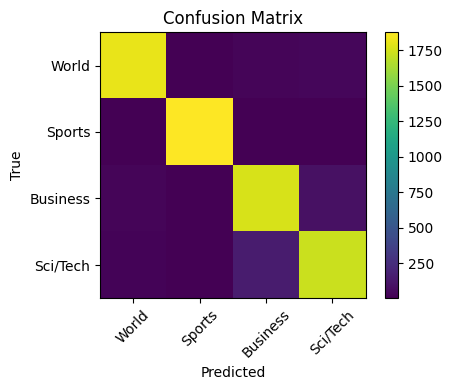

array([[1816,    8,   35,   41],
       [   8, 1875,   10,    7],
       [  33,   10, 1763,   94],
       [  23,    7,  148, 1722]])

In [23]:
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(id2label))
plt.xticks(tick_marks, [id2label[i] for i in range(4)], rotation=45)
plt.yticks(tick_marks, [id2label[i] for i in range(4)])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
plt.show()
cm

## Save Model & Tokenizer
Persist best model and label maps.


In [24]:
save_dir = "./bert_agnews_model"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)
with open(os.path.join(save_dir, "id2label.json"), "w") as f: json.dump(id2label, f)
with open(os.path.join(save_dir, "label2id.json"), "w") as f: json.dump(label2id, f)
os.listdir(save_dir)


['tokenizer.json',
 'training_args.bin',
 'model.safetensors',
 'config.json',
 'id2label.json',
 'special_tokens_map.json',
 'label2id.json',
 'vocab.txt',
 'tokenizer_config.json']

## Inference Pipeline
Convenience wrapper for single/batch predictions.


In [25]:
pipe = TextClassificationPipeline(
    model=model, tokenizer=tokenizer, return_all_scores=False, device=0 if torch.cuda.is_available() else -1
)

def predict_topic(texts):
    if isinstance(texts, str): texts = [texts]
    res = pipe(texts, truncation=True)
    return [{"label": r["label"], "score": float(r["score"])} for r in res]

predict_topic("Apple shares jump as new iPhone sales beat expectations")


Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[{'label': 'Sci/Tech', 'score': 0.61848384141922}]

## Batch Predictions (Smoke Test)
Sanity check on diverse headlines.


In [26]:
samples = [
    "NASA announces new mission to Mars next year",
    "Manchester United secure dramatic win in Champions League",
    "Stock markets rally after better-than-expected earnings",
    "New AI technique promises breakthroughs in robotics"
]
predict_topic(samples)


[{'label': 'Sci/Tech', 'score': 0.9927817583084106},
 {'label': 'World', 'score': 0.5267494916915894},
 {'label': 'Business', 'score': 0.9837312698364258},
 {'label': 'Sci/Tech', 'score': 0.9775589108467102}]

## Efficiency Notes
Why these hyperparameters and flags.


In [27]:
efficiency = {
    "fp16": torch.cuda.is_available(),
    "batch_train": 16,
    "batch_eval": 32,
    "epochs": 3,
    "lr": 2e-5,
    "warmup_ratio": 0.06,
    "weight_decay": 0.01
}
efficiency


{'fp16': True,
 'batch_train': 16,
 'batch_eval': 32,
 'epochs': 3,
 'lr': 2e-05,
 'warmup_ratio': 0.06,
 'weight_decay': 0.01}

## Export Minimal Artifacts
Store only what’s needed for serving.


In [28]:
export_dir = "./serve_artifacts"
os.makedirs(export_dir, exist_ok=True)
model.save_pretrained(export_dir)
tokenizer.save_pretrained(export_dir)
with open(os.path.join(export_dir, "labels.json"), "w") as f: json.dump(id2label, f)
sorted(os.listdir(export_dir))


['config.json',
 'labels.json',
 'model.safetensors',
 'special_tokens_map.json',
 'tokenizer.json',
 'tokenizer_config.json',
 'vocab.txt']

## Gradio App
Simple UI for local demo; run `demo.launch()` when needed.


In [29]:


def load_components(model_dir="./serve_artifacts"):
    tok = AutoTokenizer.from_pretrained(model_dir)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_dir)
    device = 0 if torch.cuda.is_available() else -1
    return TextClassificationPipeline(model=mdl, tokenizer=tok, device=device)

pipe_gr = load_components()

def predict_gr(text):
    if not text.strip():
        return "Please enter a headline."
    out = pipe_gr(text, truncation=True, return_all_scores=False)[0]
    return f"Predicted: {out['label']}  (confidence: {out['score']:.4f})"

demo = gr.Interface(
    fn=predict_gr,
    inputs=gr.Textbox(lines=3, label="Enter News Headline"),
    outputs=gr.Textbox(label="Prediction"),
    title="AG News Topic Classifier (BERT)",
    description="World • Sports • Business • Sci/Tech"
)

# To run: demo.launch(share=False)
"Gradio interface ready (call demo.launch() to start)."


Device set to use cuda:0


'Gradio interface ready (call demo.launch() to start).'

In [30]:
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a180e201e34873eca8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Sanity Prediction
One more quick inference.


In [31]:
predict_topic("FIFA reveals World Cup schedule; opening match set for June")


[{'label': 'Sports', 'score': 0.7561111450195312}]

## Save Metrics Report
Write validation/test metrics to JSON for submission.


In [32]:
summary = {
    "validation": {k: float(v) for k,v in (val_metrics or {}).items()},
    "test": {k: float(v) for k,v in (test_metrics or {}).items()},
    "model_name": MODEL_NAME,
    "labels": id2label,
    "seed": SEED
}
os.makedirs("./reports", exist_ok=True)
with open("./reports/metrics.json", "w") as f:
    json.dump(summary, f, indent=2)
summary


{'validation': {'eval_loss': 0.18145263195037842,
  'eval_accuracy': 0.947,
  'eval_f1_macro': 0.9468376423598361,
  'eval_runtime': 18.8874,
  'eval_samples_per_second': 635.345,
  'eval_steps_per_second': 19.855,
  'epoch': 3.0},
 'test': {'eval_loss': 0.18868623673915863,
  'eval_accuracy': 0.9442105263157895,
  'eval_f1_macro': 0.9442729531894516,
  'eval_runtime': 11.7519,
  'eval_samples_per_second': 646.701,
  'eval_steps_per_second': 20.252,
  'epoch': 3.0},
 'model_name': 'bert-base-uncased',
 'labels': {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'},
 'seed': 42}

## Dataset Distribution
Class balance in training set (counts).


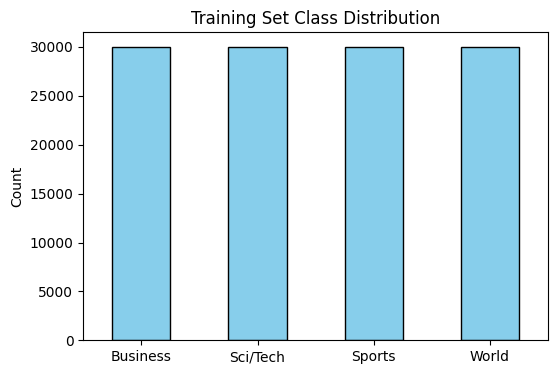

,count
Business,30000
Sci/Tech,30000
Sports,30000
World,30000


In [33]:

train_labels = [id2label[l] for l in raw["train"]["label"]]
label_counts = pd.Series(train_labels).value_counts()

fig = plt.figure(figsize=(6,4))
label_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Training Set Class Distribution")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()
label_counts


## Training Loss Curve
Plot training vs evaluation loss across epochs.


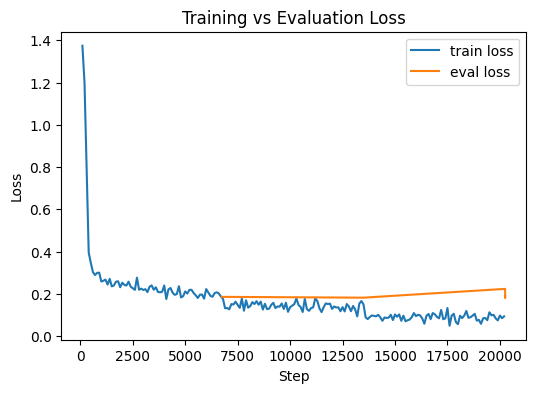

In [34]:
history = trainer.state.log_history
df_hist = pd.DataFrame(history)

fig = plt.figure(figsize=(6,4))
plt.plot(df_hist[df_hist["loss"].notnull()]["step"], df_hist[df_hist["loss"].notnull()]["loss"], label="train loss")
plt.plot(df_hist[df_hist["eval_loss"].notnull()]["step"], df_hist[df_hist["eval_loss"].notnull()]["eval_loss"], label="eval loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.show()


## Accuracy Curve
Track accuracy over training epochs.


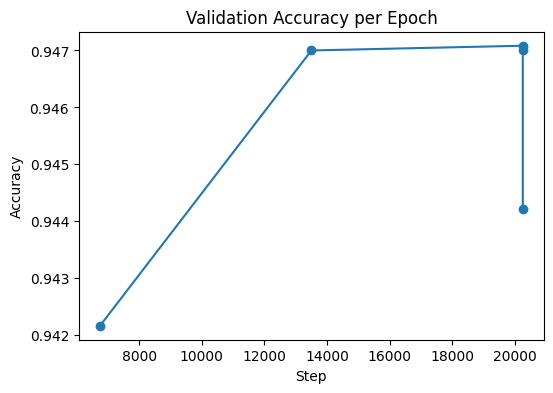

In [35]:
fig = plt.figure(figsize=(6,4))
plt.plot(df_hist[df_hist["eval_accuracy"].notnull()]["step"], df_hist[df_hist["eval_accuracy"].notnull()]["eval_accuracy"], marker="o")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.show()


## Macro-F1 Curve
Macro-F1 per epoch during training.


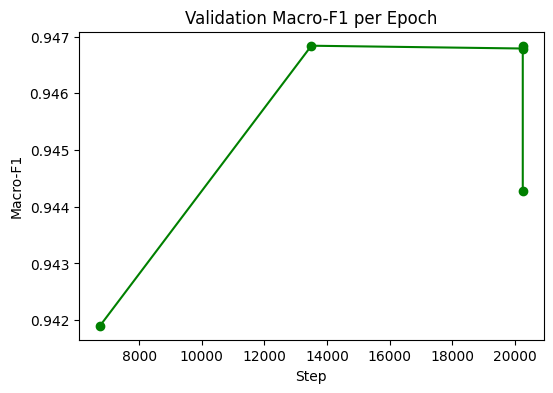

In [36]:
fig = plt.figure(figsize=(6,4))
plt.plot(df_hist[df_hist["eval_f1_macro"].notnull()]["step"], df_hist[df_hist["eval_f1_macro"].notnull()]["eval_f1_macro"], marker="o", color="green")
plt.xlabel("Step")
plt.ylabel("Macro-F1")
plt.title("Validation Macro-F1 per Epoch")
plt.show()


## Prediction Confidence Distribution
Check how confident the model is on test set predictions.


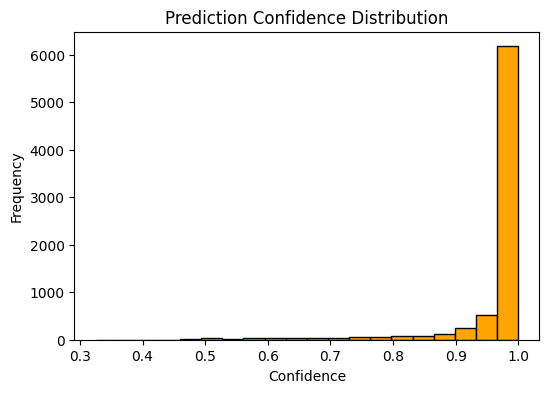

In [37]:
probs = torch.nn.functional.softmax(torch.tensor(preds.predictions), dim=1).numpy()
max_conf = probs.max(axis=1)

fig = plt.figure(figsize=(6,4))
plt.hist(max_conf, bins=20, color="orange", edgecolor="black")
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()


## Extract CLS Embeddings
Use BERT to get hidden states (CLS token) for visualization.


In [38]:

loader = DataLoader(ds["test"], batch_size=64, shuffle=False, collate_fn=collator)
model.eval()

embeddings, labels_emb = [], []
with torch.no_grad():
    for batch in loader:
        batch = {k:v.to(model.device) for k,v in batch.items()}
        outputs = model.bert(**{k:batch[k] for k in ["input_ids","attention_mask"]})
        cls_emb = outputs.last_hidden_state[:,0,:]   # CLS token
        embeddings.append(cls_emb.cpu())
        labels_emb.extend(batch["labels"].cpu().numpy())

embeddings = torch.cat(embeddings).numpy()
labels_emb = np.array(labels_emb)
embeddings.shape, labels_emb.shape


((7600, 768), (7600,))

## Dimensionality Reduction
Use t-SNE to reduce embeddings to 3D for plotting.


In [39]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=SEED, perplexity=30, init="random", learning_rate="auto")
emb_3d = tsne.fit_transform(embeddings)
emb_3d.shape


(7600, 3)

## 3D Scatter Plot
Visualize test set embeddings colored by true labels.


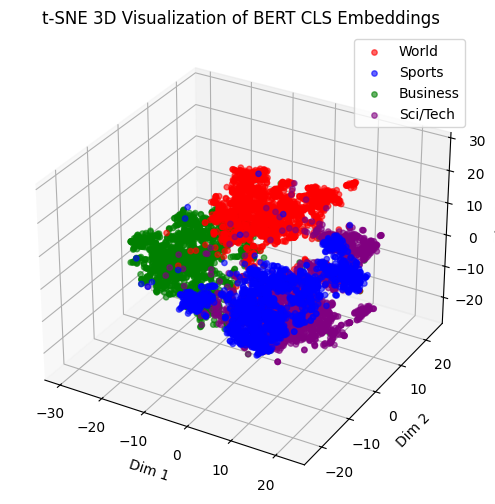

In [41]:

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

colors = ["red","blue","green","purple"]
for i, label in enumerate(id2label.values()):
    idx = labels_emb == i
    ax.scatter(emb_3d[idx,0], emb_3d[idx,1], emb_3d[idx,2], s=15, c=colors[i], label=label, alpha=0.6)

ax.set_title("t-SNE 3D Visualization of BERT CLS Embeddings")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.set_zlabel("Dim 3")
ax.legend()
plt.show()
